In [67]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy.stats import norm

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
missing = train.isnull().sum()
missing = missing[missing>2]

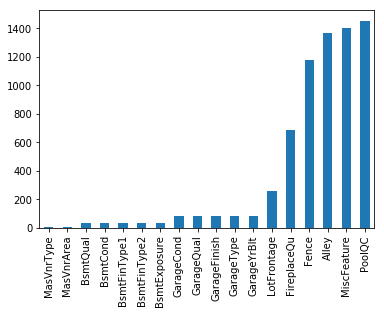

In [12]:
missing.sort_values(inplace = True)
missing.plot.bar()

In [20]:
train = train.drop(train[missing.index],1)
test = test.drop(test[missing.index],1)

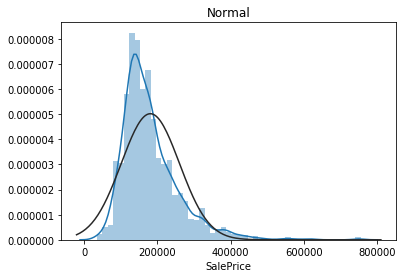

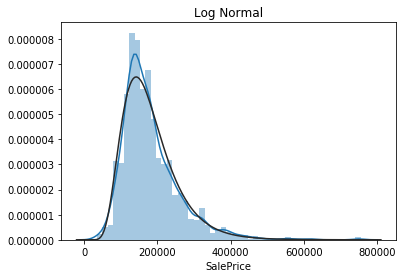

In [24]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, fit = norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, fit = st.lognorm)

In [25]:
train['SalePrice']= np.log(train['SalePrice'])

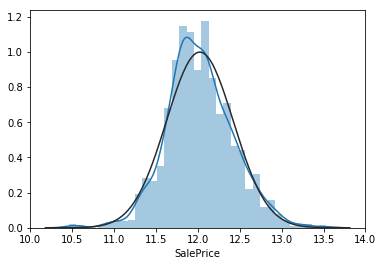

In [28]:
sns.distplot(train['SalePrice'], fit = norm)

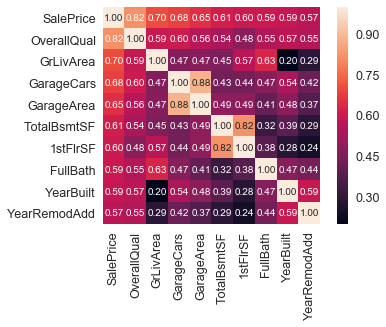

In [30]:
k = 10 #number of variables for heatmap
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

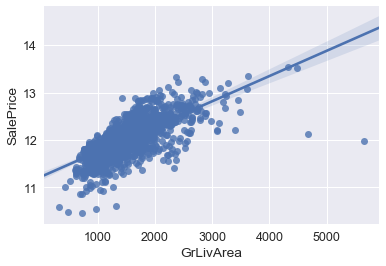

In [31]:
sns.regplot('GrLivArea','SalePrice', data =train)

In [35]:
LargestLiv = train.sort_values(by ='GrLivArea', ascending = False)[:2].index

In [41]:
train=train.drop(LargestLiv)

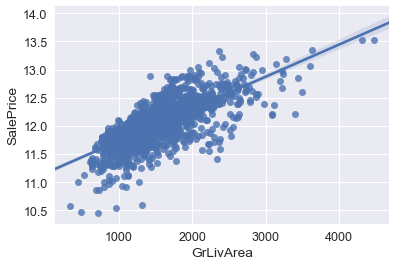

In [42]:
sns.regplot('GrLivArea','SalePrice', data =train)

In [48]:
xtrain = pd.get_dummies(train)
xtest = pd.get_dummies(test)

In [49]:
y = xtrain['SalePrice']
del(xtrain['SalePrice'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))


X_train : (1020, 220)
X_test : (438, 220)
y_train : (1020,)
y_test : (438,)


In [59]:
numerical = [f for f in train.columns if train.dtypes[f]!=object]
numerical.remove('SalePrice')
numerical.remove('Id')

In [62]:
X_train.loc[:,numerical]= StandardScaler().fit_transform(X_train.loc[:,numerical])
X_test.loc[:,numerical]= StandardScaler().fit_transform(X_test.loc[:,numerical])

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [65]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

RMSE on Training set : 0.123862146984
RMSE on Test set : 0.157388528133


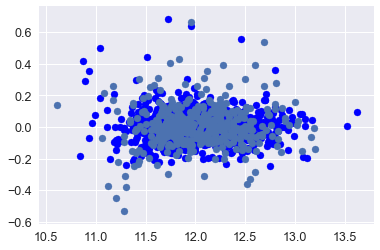

In [71]:
plt.scatter(y_train_pred, y_train_pred-y_train, c = 'blue')
plt.scatter(y_test_pred, y_test_pred - y_test)

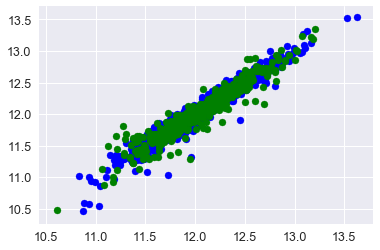

In [74]:
plt.scatter(y_train_pred, y_train, color = 'blue')
plt.scatter(y_test_pred, y_test, color = 'green')

In [114]:
missingTest = xtest.isnull().sum()
missingTest = missingTest[missingTest>0]

In [88]:
xtest1 = xtest.fillna(0)

In [116]:
print(xtest1.shape)
print(xtrain.shape)

print(train.shape)
print(train.shape)

(1459, 220)
(1458, 220)
(1458, 63)
(1458, 63)


In [94]:
xtest1 = xtest1.reindex(columns = xtrain.columns,fill_value=0)

In [118]:
xtest1.loc[:,numerical]= StandardScaler().fit_transform(xtest1.loc[:,numerical])

In [119]:
testSales= lr.predict(xtest1)

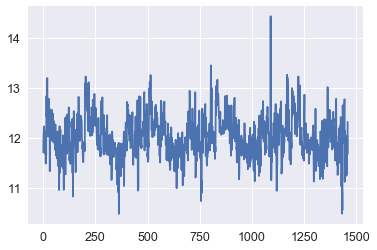

In [120]:
plt.plot(testSales)

In [122]:
np.exp(testSales[1])

165741.06307844471

In [123]:
testSales1 = np.exp(testSales)

In [125]:
submission = pd.DataFrame({'Id': xtest1['Id'], 'SalePrice': testSales1})

In [126]:
submission.head()

,Id,SalePrice
0,1461,121715.492541
1,1462,165741.063078
2,1463,189510.434351
3,1464,202590.676399
4,1465,205044.264775


In [129]:
submission.to_csv('TestSales.csv')